# Weekly Project 5
## Global Registration implementation.
## Task 1
Today your project is to implement a global registration algorithm.

It should be able to roughly align two pointclouds.
1. Implement global registration
2. Can you fit **r1.pcd** and **r2.pcd**?
3. Can you fit **car1.ply** and **car2.ply**?
These are in the *global_registration* folder



## Task 2 (Challange)
Challanges attempt either or both:
- Implement local registration.

- Attempt to reconstruct the car from the images in *car_challange* folder.

You can use the exercises from monday as a starting point.

## Task 1
---

In [51]:
import open3d as o3d
import numpy as np
import copy
import matplotlib 
# helper function for drawing if you want it to be more clear which is which set recolor=True
def draw_registrations(source, target, transformation = None, recolor = False):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    if(recolor):
        source_temp.paint_uniform_color([1, 0.706, 0])
        target_temp.paint_uniform_color([0, 0.651, 0.929])
    if(transformation is not None):
        source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [4]:
####
# Downsample and find features here
####

# Load
source = o3d.io.read_point_cloud("./global_registration/car1.ply")
target = o3d.io.read_point_cloud("./global_registration/car2.ply")
# Used for downsampling.
voxel_size = 0.05

# Code
source_sample = source.voxel_down_sample(voxel_size)
target_sample = target.voxel_down_sample(voxel_size)

default_tree = o3d.geometry.KDTreeSearchParamHybrid(radius=10,max_nn=60)

source_sample.estimate_normals()
target_sample.estimate_normals()

source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source_sample, default_tree)
target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(target_sample, default_tree)

print(len(source_sample.points))
print(len(target_sample.points))

3490
3606


In [27]:
corr_length = 0.9
distance_threshold = voxel_size * 1.5

c0 = o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(corr_length)
c1 = o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
c2 = o3d.pipelines.registration.CorrespondenceCheckerBasedOnNormal(0.095)
point_to_point =  o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=False)

checker_list = [c0,c1,c2]

ransac_result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_sample, target_sample, 
    source_fpfh, target_fpfh, 
    True,
    distance_threshold,
    point_to_point,
    checkers = checker_list)

draw_registrations(source, target, ransac_result.transformation, True)

## Task 2 (Challange)
---

In [8]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("./car_challange/rgb/0000001.jpg")
depth_raw0 = o3d.io.read_image("./car_challange/depth/0000001.png")

color_raw1 = o3d.io.read_image("./car_challange/rgb/0000005.jpg")
depth_raw1 = o3d.io.read_image("./car_challange/depth/0000005.png")

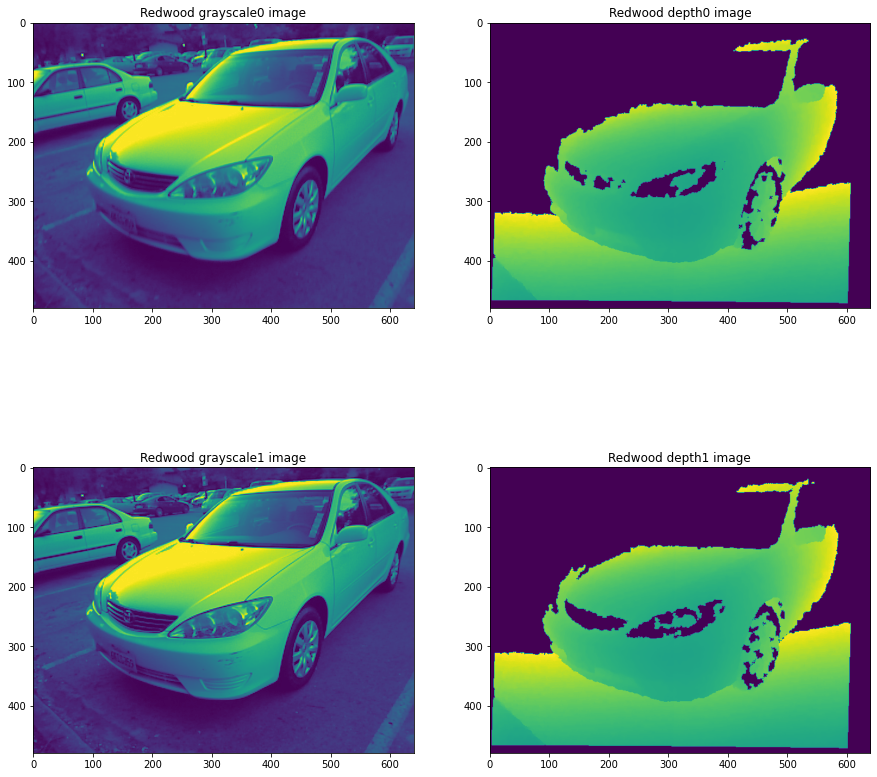

In [15]:
import matplotlib.pyplot as plt

rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = True)

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()

In [16]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)

In [19]:
# Parameters
threshold = 0.02
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=4.492835e-01, inlier_rmse=1.156006e-02, and correspondence_set size of 74679
Access transformation to get result.


In [21]:
source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30),fast_normal_computation=True)
target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30),fast_normal_computation=True)

point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init,point_to_plane)

draw_registrations(source, target, recolor=True)

# Algorithm
---

In [53]:
import cv2
from matplotlib import pyplot as pyplot
import numpy as np
import copy
import scipy
from scipy import spatial 
import random
import sys
import math

#Kabsch Algorithm
def compute_transformation(source,target):

    #the centroid of source points
    cs = np.zeros((3,1))
    
    #the centroid of target points
    ct = copy.deepcopy(cs)
    cs[0] = np.mean(source[:][0]);cs[1]=np.mean(source[:][1]);cs[2]=np.mean(source[:][2])
    ct[0] = np.mean(target[:][0]);cs[1]=np.mean(target[:][1]);cs[2]=np.mean(target[:][2])
    
    #covariance matrix
    cov = np.zeros((3,3))
    
    #translate the centroids of both models to the origin of the coordinate system (0,0,0)
    #subtract from each point coordinates the coordinates of its corresponding centroid
    for s, t in zip(source,target):
        sources = s.reshape(-1,1) - cs
        targets = t.reshape(-1,1) - ct
        cov = cov + np.dot(sources,np.transpose(targets))
        
    #SVD (singular values decomposition)
    u,w,v = np.linalg.svd(cov)
    
    #rotation matrix
    R = np.dot(u,np.transpose(v))
    
    #Transformation vector
    T = ct - np.dot(R,cs)
    return R, T

#compute the root mean square error between source and target
def compute_rmse(source, targets, R, T):
    rmse = 0
    
    # transformation
    points = [np.dot(R,point.reshape(-1,1) + T) for point in source]
    for point, target in zip(points, targets):
        error = target.reshape(-1,1) - point
        rmse = rmse + math.sqrt(error[0]**2 + error[1]**2 + error[2]**2)
    return rmse


def registration_RANSAC(source, target, source_feature, target_feature, ransac_n=4, max_iteration=1000):
    #the intention of RANSAC is to get the optimal transformation between the source and target point cloud
    s, t = np.asarray(source.points), np.asarray(target.points)
    sf, tf = np.transpose(source_feature.data), np.transpose(target_feature.data)
    
    #create a KD tree
    tree = spatial.KDTree(tf)
    corres_stock = tree.query(sf)[1]
    opt_rmse = float("inf")
    for i in range(max_iteration):
        #take ransac_n points randomly
        idx = [random.randint(0, s.shape[0] - 1) for j in range(ransac_n)]
        corres_idx = corres_stock[idx]
        
        source_point = s[idx,...]
        target_point = t[corres_idx,...]
        
        #estimate transformation
        R, T = compute_transformation(source_point, target_point)
                                      
        # calculate rmse for all points
        rmse = compute_rmse(s, t[corres_stock,...], R, T)
                                      
        #compare rmse and optimal rmse and then store the smaller one as optimal values
        if rmse < opt_rmse:
            print(rmse)
            opt_rmse = rmse
            opt_R = R
            opt_T = T
                                      
    return opt_R, opt_T

#used for downsampling
voxel_size = 0.05

#this is to get the fpfh features, just call the library
def get_fpfh(cp):
    cp = cp.voxel_down_sample(voxel_size)
    cp.estimate_normals()
    return cp, o3d.pipelines.registration.compute_fpfh_feature(cp, o3d.geometry.KDTreeSearchParamHybrid(radius=10,max_nn=500))

In [ ]:
# Load
source = o3d.io.read_point_cloud("./global_registration/r1.pcd")
target = o3d.io.read_point_cloud("./global_registration/r2.pcd")

#if we want to use RANSAC registration, get_fpfh features should be acquired firstly                 
r1, f1 = get_fpfh(source)
r2, f2 = get_fpfh(target)
R, T = registration_RANSAC(r1, r2, f1, f2)

#transformation matrix is formed by R, T based on np.hstack and np.vstack(corporate two matrices by rows)
#Notice we need add the last row [0 0 0 1] to make it homogeneous 
transformation = np.vstack((np.hstack((np.float64(R), np.float64(T))), np.array([0,0,0,1])))
draw_registrations(r1, r2, transformation, True)

42093.820930784044
32563.17843450976
26395.931803792064
24213.949112206214
10980.478880285506
10220.328179607446
8789.689192316766
8264.393384355553
8124.019635251052
6906.521159570766
6602.886963759112
